In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from enum import Enum
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Input, Embedding, Dropout , concatenate
from keras.optimizers.legacy import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.callbacks import Callback, EarlyStopping
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
from wordcloud import WordCloud
from matplotlib_venn import venn3
import missingno as msno
from IPython.display import HTML

pd.set_option('display.width', None)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

/Users/rohitanilkumar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rohitanilkumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rohitanilkumar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rohitanilkumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rohitanilkumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
class CONSTANTS(Enum):
    GLOVE = "/Users/rohitanilkumar/Downloads/glove.6B.50d.txt"
    INPUT = "/Users/rohitanilkumar/Downloads/jigsaw-toxic-comment-classification-challenge/"
    MODEL_DIAGRAM = "/Users/rohitanilkumar/Downloads/jigsaw-toxic-comment-classification-challenge/multichannel.png"
    MODEL_PATH = '/Users/rohitanilkumar/Downloads/jigsaw-toxic-comment-classification-challenge/model.keras'
    OUTPUT_PATH = '/Users/rohitanilkumar/Downloads/jigsaw-toxic-comment-classification-challenge/multichannel.csv'

    STOPWORDS = set(stopwords.words('english'))
    UNIQUE_TOKENS = 30000
    DIMENSIONALITY = 50
    MAXLENGTH = 100
    OUTPUTNODES = 6

    ENCODING = "ISO-8859-1"
    BATCH = 100
    EPOCH = 25
    LOSS = 'binary_crossentropy'
    OPTIMIZER = Adam(learning_rate=0.0001)
    METRICS = ['accuracy']
    ACTIVATION_FUNCTION = ['relu', 'sigmoid']
    
    DELTA = 0.0001
    PATIENCE = 2
    MONITOR = "val_loss"
    MODE = "min"

    TRAIN_SIZE = 0.95
    INTERVAL = 1
    RANDOM_SEED = 43

    LABEL_MAPPING = {
        0: "toxic",
        1: "severe_toxic",
        2: "obscene",
        3: "threat",
        4: "insult",
        5: "identity_hate"
    }
    CLASSES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    

In [3]:
class EDAVisualizer:
    def __init__(self):
        pass

    def visualize_feature_counts(self, data):
        """
        Visualizes feature counts for Exploratory Data Analysis (EDA).

        Parameters:
        - data: DataFrame containing features for visualization.
        """
        feature_counts = data.sum()
        ax = sns.barplot(x=feature_counts.index, y=feature_counts.values, alpha=0.8)
        plt.title("Feature Counts for EDA")
        plt.ylabel('Count', fontsize=12)
        plt.xlabel('Feature', fontsize=12)

        # Adding text labels to the bars
        rects = ax.patches
        labels = feature_counts.values
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

        plt.show()

    def visualize_tags_per_comment(self, data):
        """
        Visualizes the count of tags per comment for Exploratory Data Analysis (EDA).

        Parameters:
        - data: DataFrame containing tag information per comment.
        """
        row_sums = data.sum(axis=1)
        tag_counts = row_sums.value_counts()

        ax = sns.barplot(x=tag_counts.index, y=tag_counts.values, alpha=0.8, color='green')  # Change color scheme if needed
        plt.title("Tags per Comment")
        plt.ylabel('# of Occurrences', fontsize=12)
        plt.xlabel('# of Tags', fontsize=12)

        # Adding text labels to the bars
        rects = ax.patches
        labels = tag_counts.values
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

        plt.show()

    def visualize_correlation_heatmap(self, data):
        """
        Visualizes the correlation heatmap for features in the DataFrame.

        Parameters:
        - data: DataFrame containing features for correlation analysis.
        """
        temp_df = data.copy()  # Create a copy of the DataFrame to avoid modification of the original data
        corr = temp_df.corr()

        sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
        plt.title("Correlation Heatmap")
        plt.show()

    def highlight_min(data, color='yellow'):
        '''
        Highlight the minimum value in a Series or DataFrame
        '''
        attr = 'background-color: {}'.format(color)
        if isinstance(data, pd.Series):  # For a Pandas Series
            is_min = data == data.min()
            return [attr if v else '' for v in is_min]
        else:  # For a Pandas DataFrame
            is_min = data == data.min().min()
            return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)
    
    
    def check_overlaps(self, dataframe):
        # Replacing '1's with NaN in the DataFrame
        train_msno = dataframe.replace(1, float("NaN"))
        
        # Visualizing overlaps among 6 columns using missingno's matrix
        msno.matrix(train_msno)
        
    def create_venn_diagram(self, df):
        """
        Creates a Venn diagram illustrating overlaps among 'toxic', 'insult', and 'obscene' columns in the given DataFrame.

        Parameters:
        - df: DataFrame containing columns 'toxic', 'insult', and 'obscene'
        """
        t = df[(df['toxic'] == 1) & (df['insult'] == 0) & (df['obscene'] == 0)].shape[0]
        i = df[(df['toxic'] == 0) & (df['insult'] == 1) & (df['obscene'] == 0)].shape[0]
        o = df[(df['toxic'] == 0) & (df['insult'] == 0) & (df['obscene'] == 1)].shape[0]

        t_i = df[(df['toxic'] == 1) & (df['insult'] == 1) & (df['obscene'] == 0)].shape[0]
        t_o = df[(df['toxic'] == 1) & (df['insult'] == 0) & (df['obscene'] == 1)].shape[0]
        i_o = df[(df['toxic'] == 0) & (df['insult'] == 1) & (df['obscene'] == 1)].shape[0]

        t_i_o = df[(df['toxic'] == 1) & (df['insult'] == 1) & (df['obscene'] == 1)].shape[0]

        # Make the diagram
        plt.figure(figsize=(8, 8))
        plt.title("Venn diagram for 'toxic', 'insult', and 'obscene'")
        venn3(subsets=(t, i, t_i, o, t_o, i_o, t_i_o),
              set_labels=('toxic', 'insult', 'obscene'))
        plt.show()
        
        
    def get_word_cloud(self, column, df, stopword):
        """
        Generates a word cloud based on the specified column in the  dataFrame.

        Parameters:
        - column: The column in the DataFrame to generate the word cloud from.
        - df: The DataFrame containing the data.
        - stopword: Stopwords for word cloud generation.
        """
        subset = df[df[column] == 1]
        text = subset.comment_text.values
        wc = WordCloud(background_color="black", max_words=100, stopwords=stopword, collocations=False)
        wc.generate(" ".join(text))
        plt.figure(figsize=(20, 10))
        plt.axis("off")
        plt.title(f"Words frequented in '{column}' Comments", fontsize=20)
        plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98)
        plt.show()

In [4]:
class MultiChannelNeuralNetwork():    
    def __init__(self) -> None:
        pass
    def lemmatizer(self, sentence):
        wnl = WordNetLemmatizer()
        for word, tag in pos_tag(word_tokenize(sentence)):
            if tag.startswith("NN"):
                yield wnl.lemmatize(word, pos='n')
            elif tag.startswith('VB'):
                yield wnl.lemmatize(word, pos='v')
            elif tag.startswith('JJ'):
                yield wnl.lemmatize(word, pos='a')
            elif tag.startswith('R'):
                yield wnl.lemmatize(word, pos='r')
            else:
                yield word

    def msg_processing(self, raw_msg):
        raw_msg = str(raw_msg)
        raw_msg = str(raw_msg.lower())
        raw_msg = re.sub(r'[^a-zA-Z]', ' ', raw_msg)
        words = raw_msg.lower().split()
        temp_words = []
        
        for i in words:
            if len(i) >= 0:
                temp_words.append(i)
        
        meaningful_words = " ".join([w for w in temp_words])
        return(" ".join(self.lemmatizer(meaningful_words)))

    def helperFunction(self, df, dataset_type):
        print ("Start data preprocessing for {d}".format(d = dataset_type))
        df = df.copy()
        df['comment_text'].fillna('Missing',inplace = True)
        cols = ['comment_text']
        df = df[cols]
        df.loc[:, 'comment_text'] = df['comment_text'].replace({r'[^\x00-\x7F]+':''}, regex=True)
        num_msg = df[cols].size
        clean_msg = []
        for i in range(0,num_msg):
            clean_msg.append(self.msg_processing(df['comment_text'][i]))
        
        df['Processed_msg'] = clean_msg
        new_df = df['Processed_msg']
        print ("Data preprocessing Ends!!!")
        return new_df

    def embedding(self, train,test):
        tokenizer = Tokenizer(num_words=CONSTANTS.UNIQUE_TOKENS.value)
        tokenizer.fit_on_texts(train)
        trainsequences = tokenizer.texts_to_sequences(train)
        traindata = pad_sequences(trainsequences, maxlen = CONSTANTS.MAXLENGTH.value)
        testsequences = tokenizer.texts_to_sequences(test)
        testdata = pad_sequences(testsequences, maxlen = CONSTANTS.MAXLENGTH.value)
        return traindata, testdata, tokenizer

    def get_coefs(self, word,*arr):
        return word, np.asarray(arr, dtype='float32')


    def embedding_matrix_generator(self, tokenizer, embedding_path):
        embeddings_index = dict(self.get_coefs(*o.strip().split()) for o in open(embedding_path, encoding="utf8"))
        
        word_index = tokenizer.word_index
        nb_words = min(CONSTANTS.UNIQUE_TOKENS.value, len(word_index))
        embedding_matrix = np.zeros((nb_words, CONSTANTS.DIMENSIONALITY.value))
        
        for word, i in word_index.items():
            if i >= CONSTANTS.UNIQUE_TOKENS.value: continue
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None: embedding_matrix[i] = embedding_vector

        return embedding_matrix

    def get_target(self, y):
        ytrain=y[CONSTANTS.CLASSES.value].values
        return ytrain


    def multi_channel_model(self, embedding_matrix):
        input1 = Input(shape = (CONSTANTS.MAXLENGTH.value,))
        embedding1 = Embedding(CONSTANTS.UNIQUE_TOKENS.value, CONSTANTS.DIMENSIONALITY.value, weights=[embedding_matrix])(input1)
        conv1 = Conv1D(filters=32, kernel_size=3, activation= CONSTANTS.ACTIVATION_FUNCTION.value[0])(embedding1)
        drop1 = Dropout(0.4)(conv1)
        pool1 = MaxPooling1D(pool_size=4)(drop1)
        gru1 = GRU(CONSTANTS.MAXLENGTH.value, dropout=0.2, recurrent_dropout=0.2)(pool1)
        
        
        input2 = Input(shape = (CONSTANTS.MAXLENGTH.value,))
        embedding2 = Embedding(CONSTANTS.UNIQUE_TOKENS.value, CONSTANTS.DIMENSIONALITY.value, weights=[embedding_matrix])(input2)
        conv2 = Conv1D(filters = 32, kernel_size = 4, activation = CONSTANTS.ACTIVATION_FUNCTION.value[0])(embedding2)
        drop2 = Dropout(0.45)(conv2)
        pool2 = MaxPooling1D(pool_size=4)(drop2)
        gru2 = GRU(CONSTANTS.MAXLENGTH.value, dropout=0.2, recurrent_dropout=0.2)(pool2)
        
        
        input3 = Input(shape = (CONSTANTS.MAXLENGTH.value,))
        embedding3 = Embedding(CONSTANTS.UNIQUE_TOKENS.value, CONSTANTS.DIMENSIONALITY.value, weights=[embedding_matrix])(input3)
        conv3 = Conv1D(filters=32, kernel_size=5, activation=CONSTANTS.ACTIVATION_FUNCTION.value[0])(embedding3)
        drop3 = Dropout(0.5)(conv3)
        pool3 = MaxPooling1D(pool_size=4)(drop3)
        gru3 = GRU(CONSTANTS.MAXLENGTH.value, dropout=0.2, recurrent_dropout=0.2)(pool3)
        
        
        merged = concatenate([gru1,gru2,gru3])
        dense1 = Dense(CONSTANTS.MAXLENGTH.value, activation=CONSTANTS.ACTIVATION_FUNCTION.value[0])(merged)
        outputs = Dense(CONSTANTS.OUTPUTNODES.value, activation=CONSTANTS.ACTIVATION_FUNCTION.value[1])(dense1)
        
        model = Model(inputs =[input1, input2, input3], outputs = outputs)
        model.compile(loss = CONSTANTS.LOSS.value, optimizer = CONSTANTS.OPTIMIZER.value, metrics = CONSTANTS.METRICS.value)
        return model

    def predict(self, model, df):
        pred = model.predict([df,df,df])
        return pred

    def plot_metrics(self, history):
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()


In [5]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

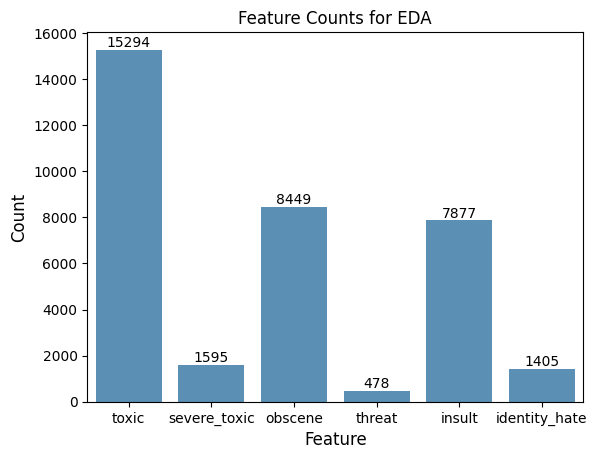

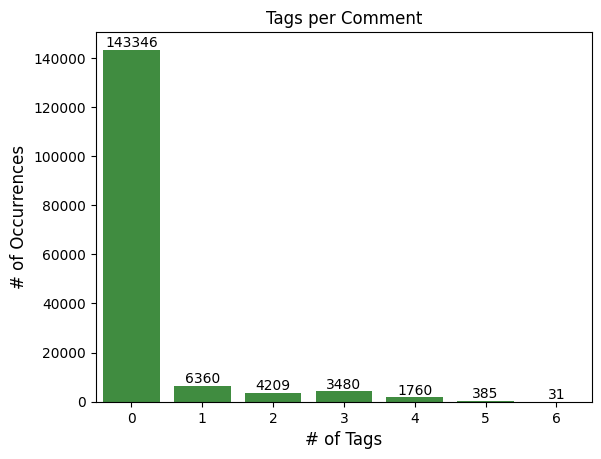

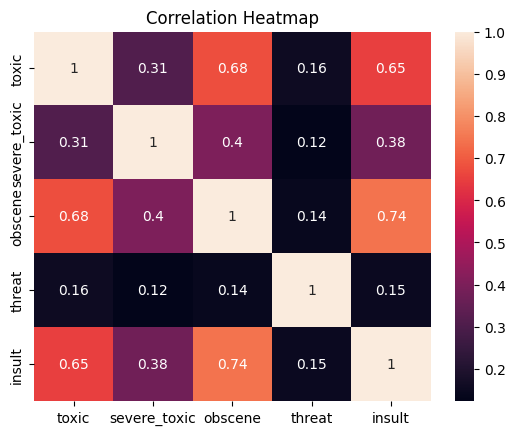

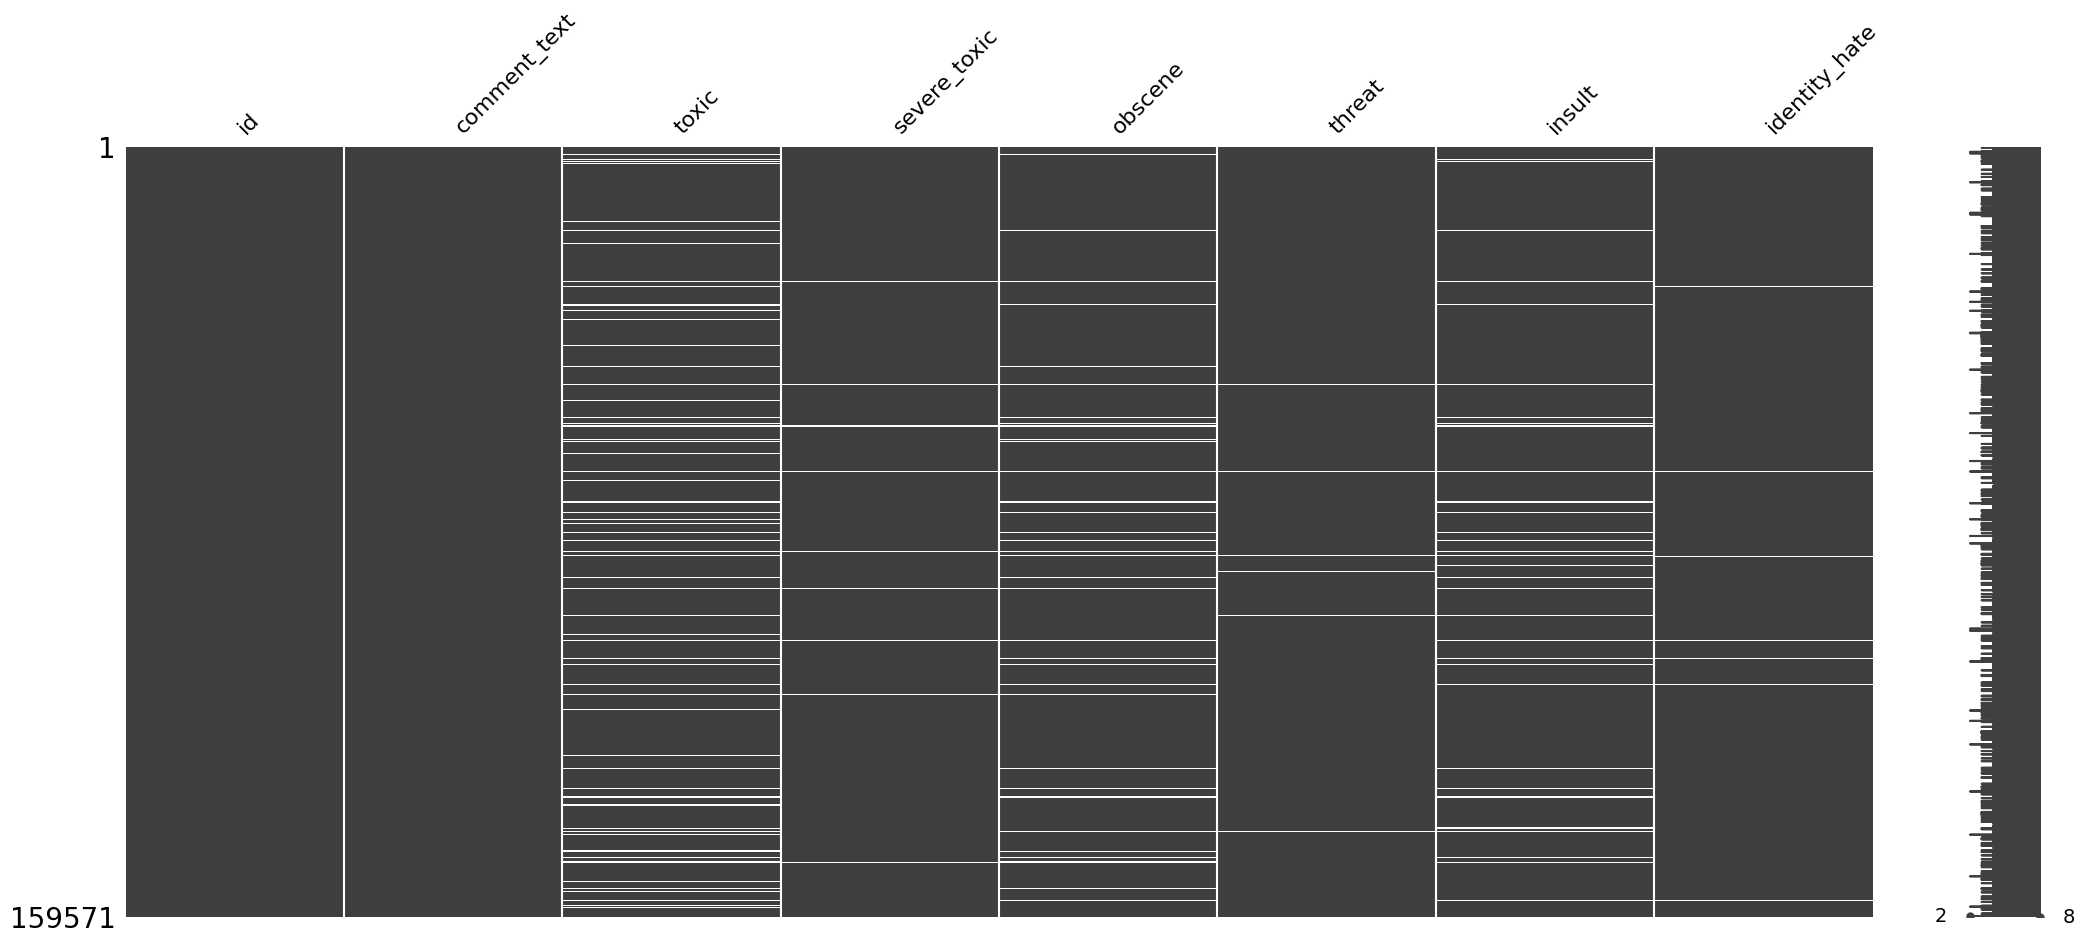

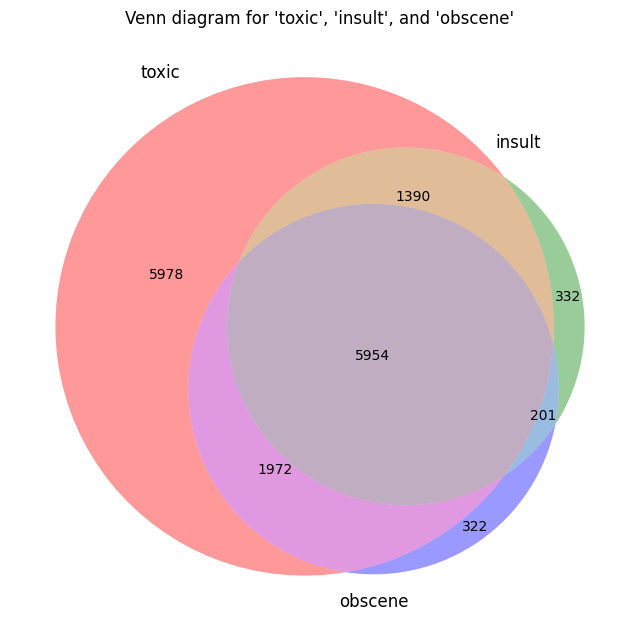

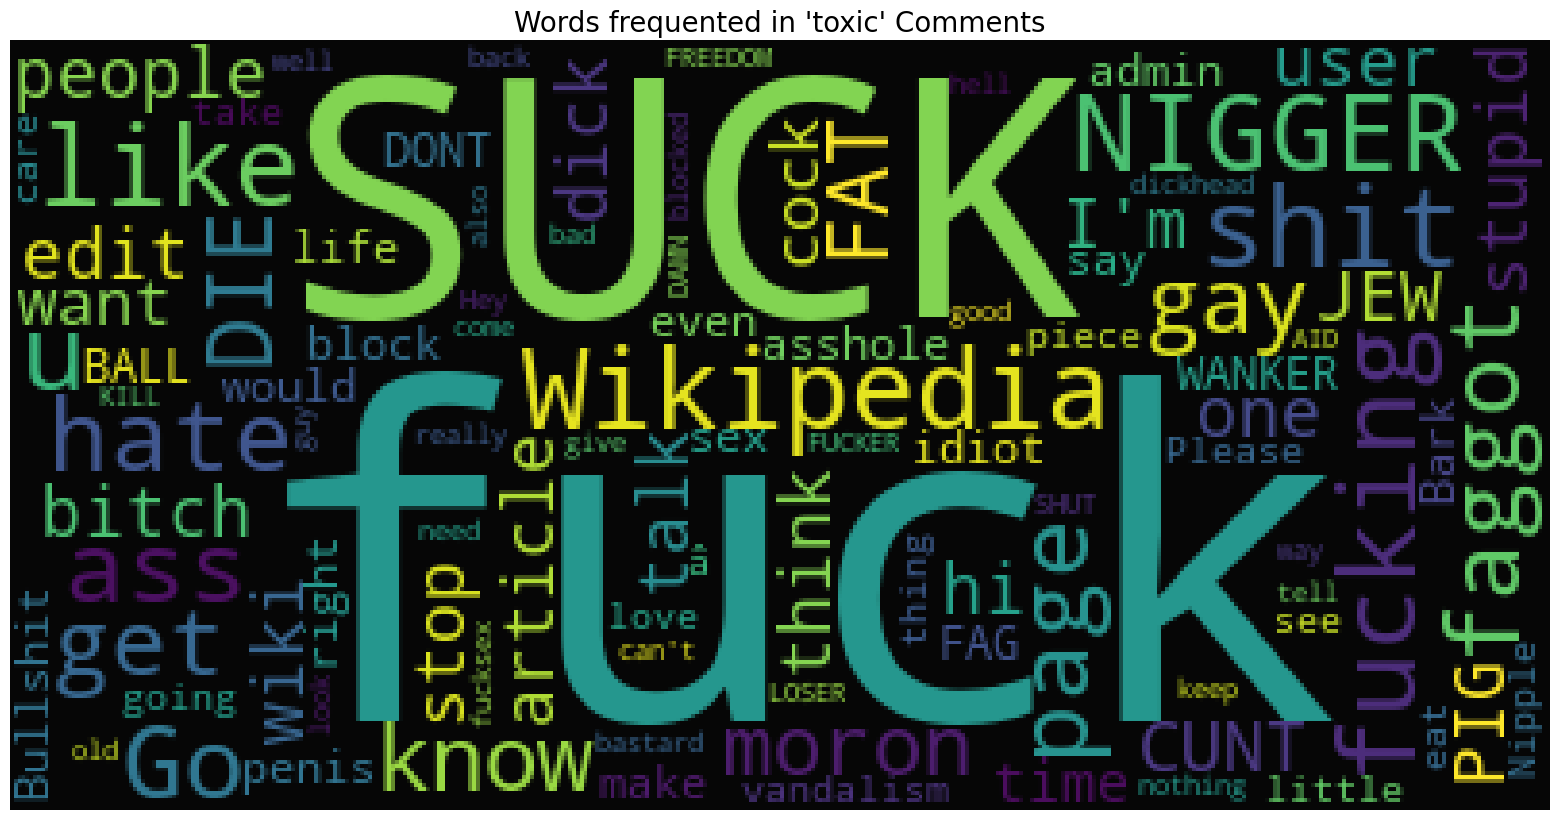

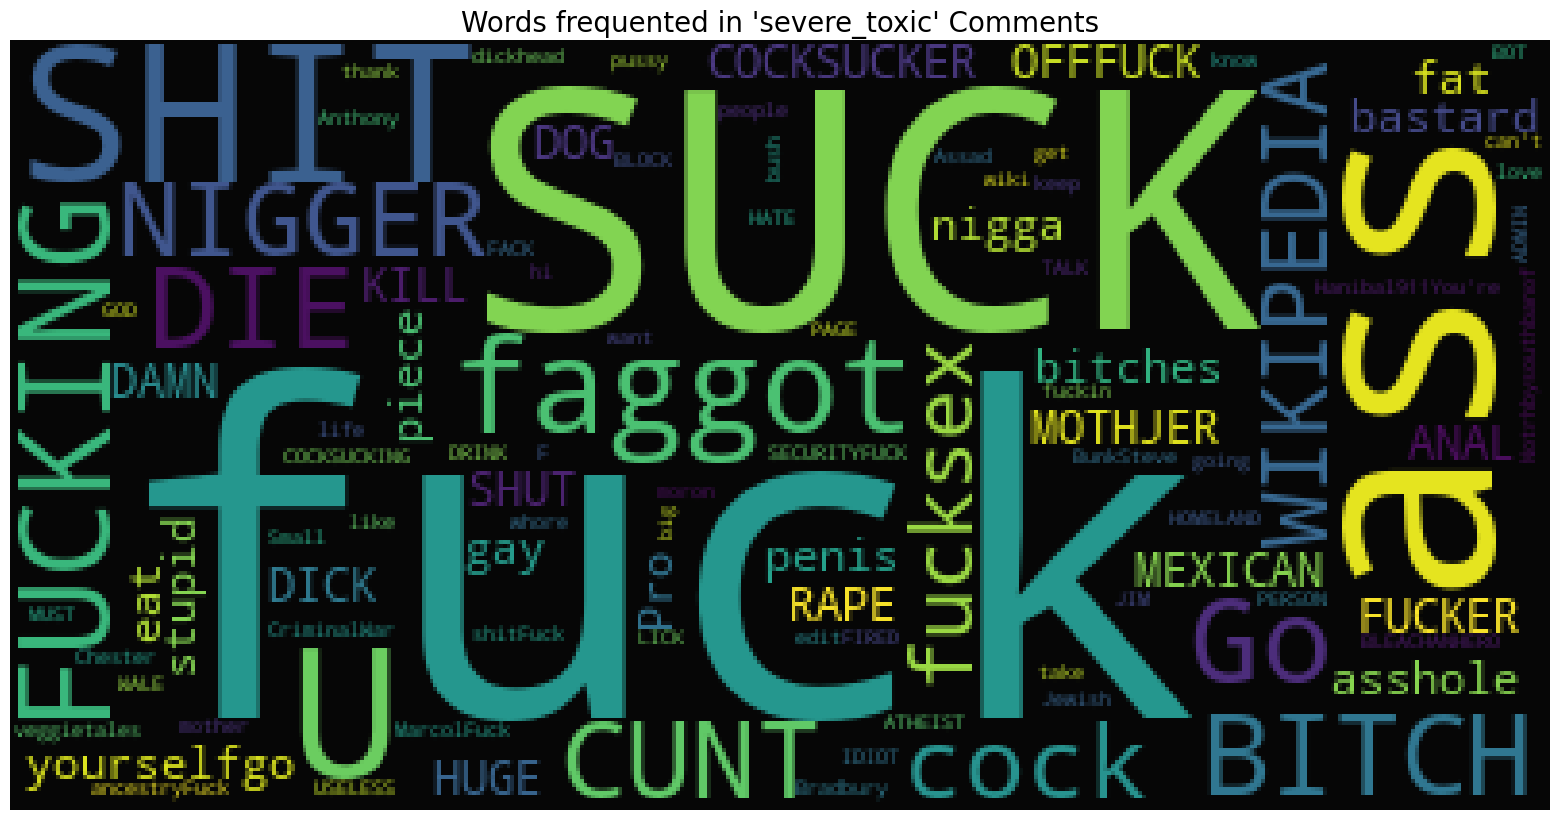

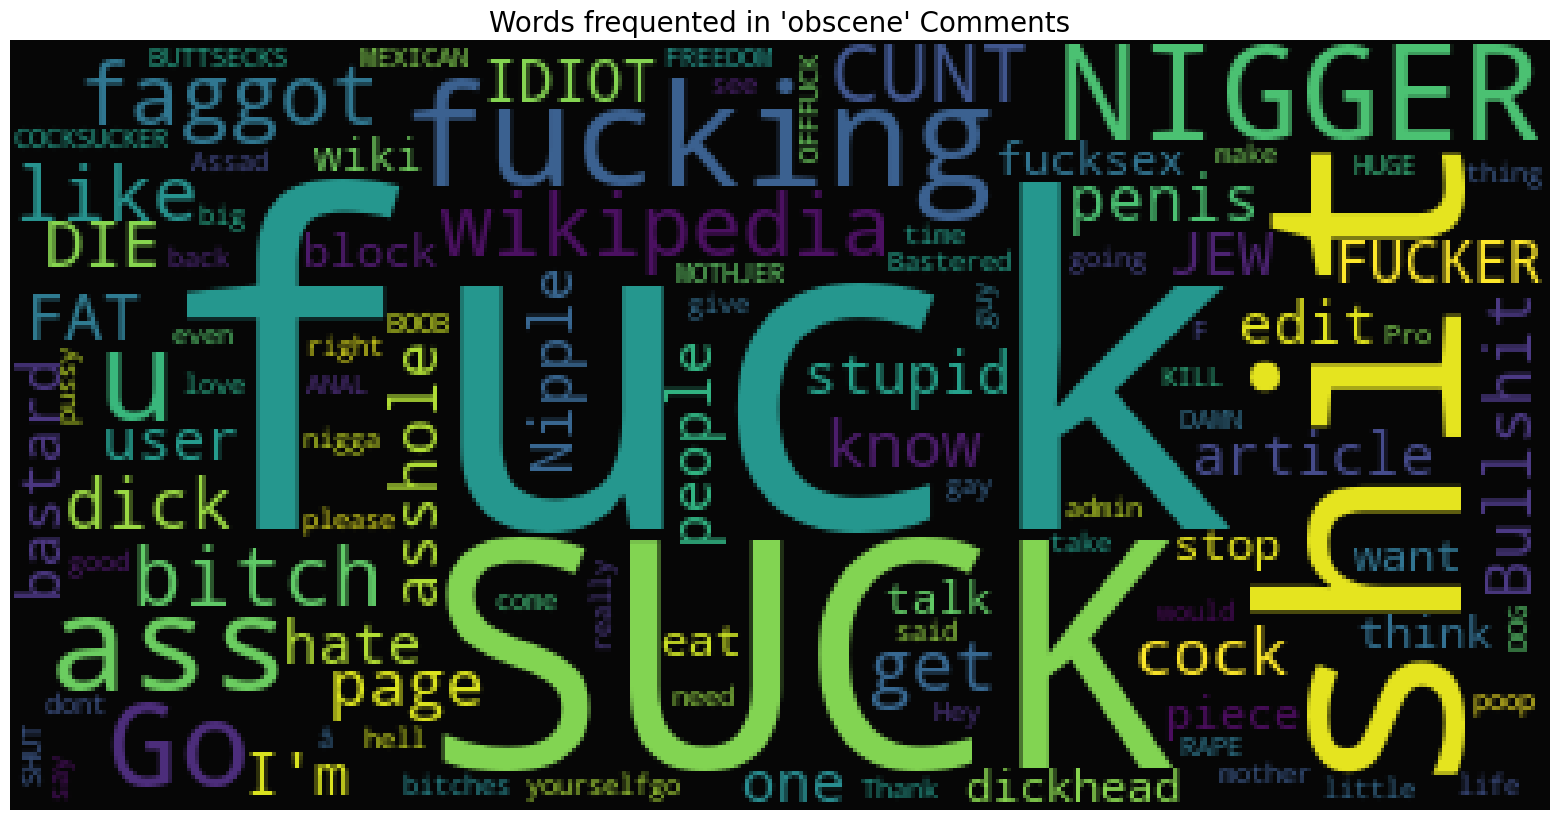

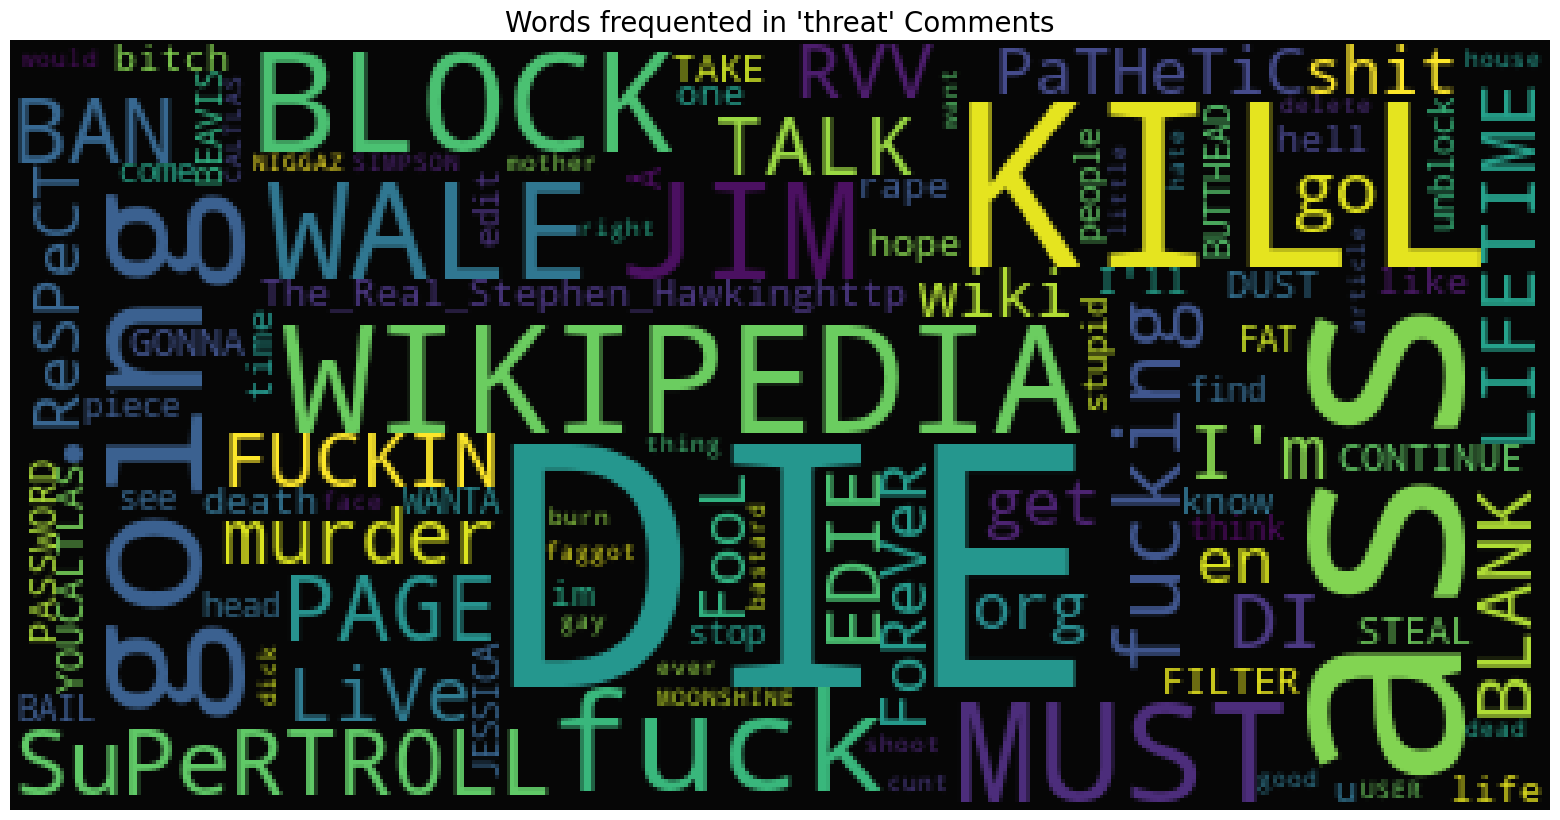

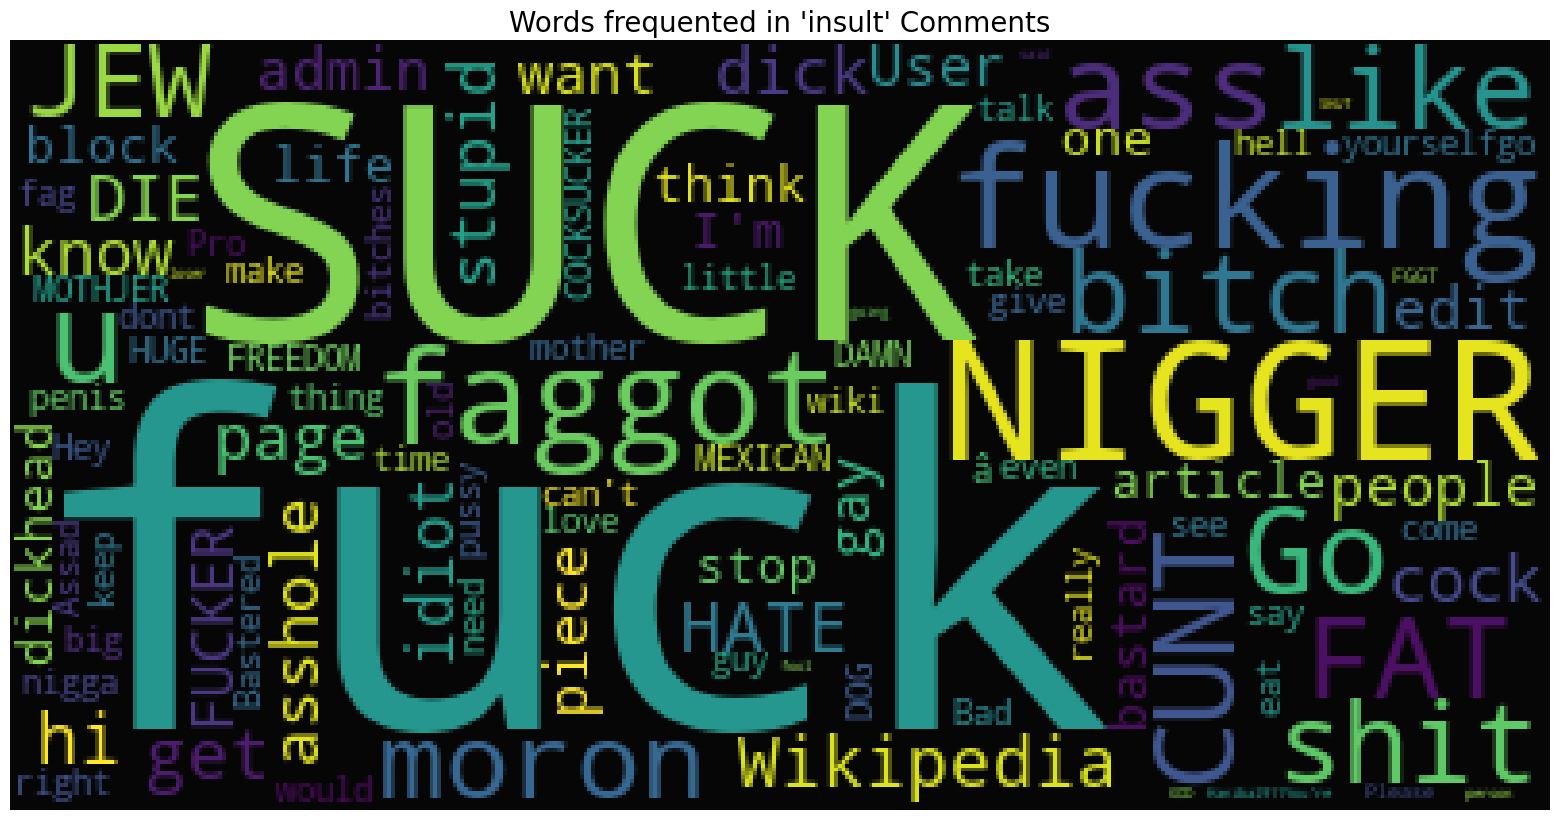

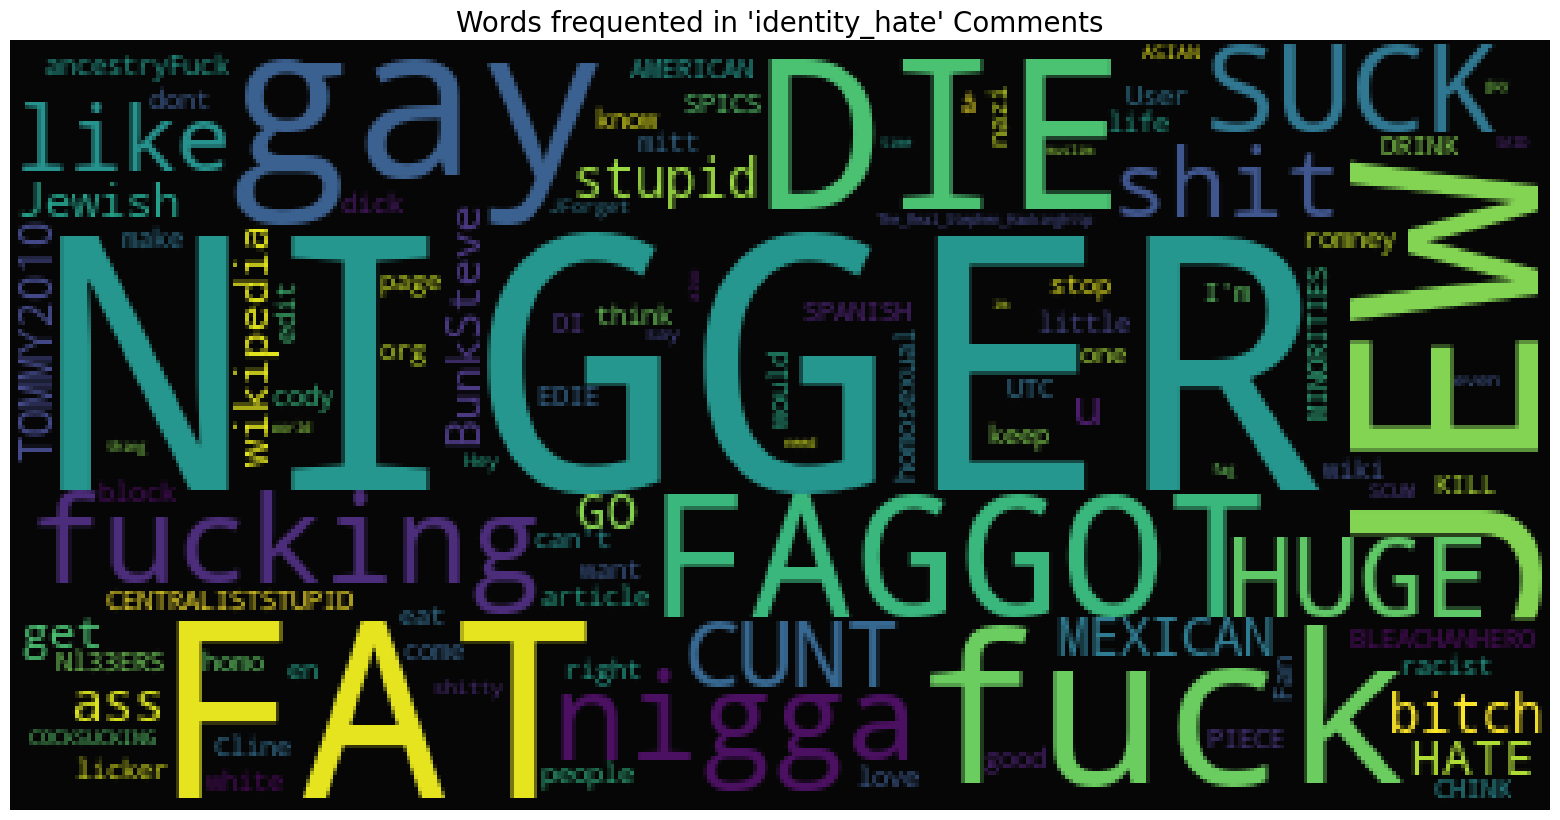

Start data preprocessing for Train dataset
Data preprocessing Ends!!!
Start data preprocessing for Test dataset
Data preprocessing Ends!!!
Saving model to /Users/rohitanilkumar/Downloads/jigsaw-toxic-comment-classification-challenge/model.keras
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                               

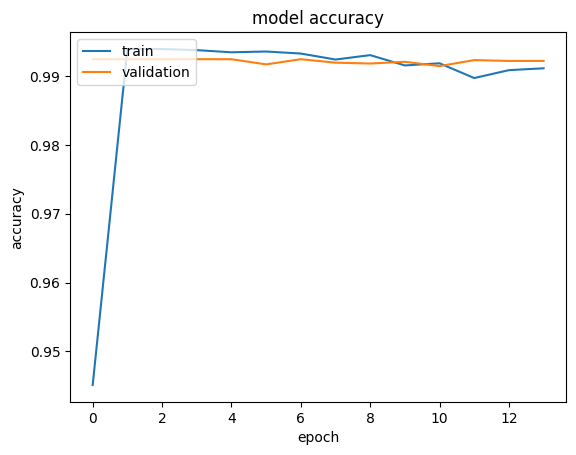

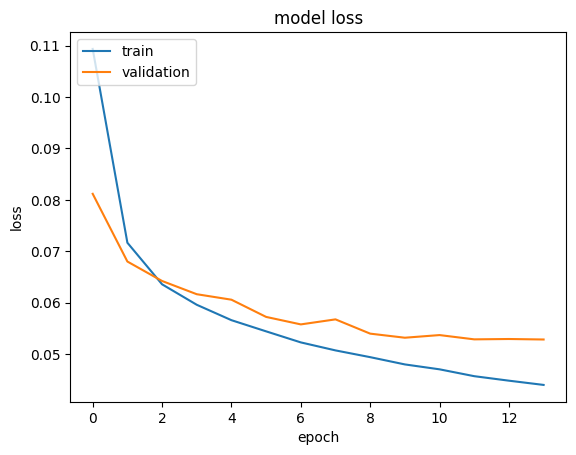

4787/4787 [==============================] - 23s 5ms/step


In [8]:
if __name__ == "__main__":

    train_df= pd.read_csv(CONSTANTS.INPUT.value + "train.csv", encoding = CONSTANTS.ENCODING.value) 
    test_df = pd.read_csv(CONSTANTS.INPUT.value + "test.csv", encoding = CONSTANTS.ENCODING.value)
    stopword = CONSTANTS.STOPWORDS.value
    ################################################################################################################
    eda_visualizer = EDAVisualizer()
    eda_visualizer.visualize_feature_counts(train_df.iloc[:, 2:])
    eda_visualizer.visualize_tags_per_comment(train_df.iloc[:, 2:])
    eda_visualizer.visualize_correlation_heatmap(train_df.iloc[:, 2:-1])
    eda_visualizer.check_overlaps(train_df)
    eda_visualizer.create_venn_diagram(train_df)

    for hate in CONSTANTS.CLASSES.value:
        eda_visualizer.get_word_cloud(hate, train_df, stopword)
    ##################################################################################################################
    
    nn_obj = MultiChannelNeuralNetwork()
    processed_train_df = nn_obj.helperFunction(train_df, "Train dataset")
    processed_test_df = nn_obj.helperFunction(test_df, "Test dataset")
    xtrain,xtest,tokenizer = nn_obj.embedding(processed_train_df, processed_test_df)
    embedding_matrix = nn_obj.embedding_matrix_generator(tokenizer, CONSTANTS.GLOVE.value)
    ytrain = nn_obj.get_target(train_df[CONSTANTS.CLASSES.value])

    X_train, X_val, y_train, y_val = train_test_split(xtrain, ytrain, train_size = CONSTANTS.TRAIN_SIZE.value, 
                                                      random_state = CONSTANTS.RANDOM_SEED.value)
    
    model = nn_obj.multi_channel_model(embedding_matrix)
    print("Saving model to {path}".format(path = CONSTANTS.MODEL_PATH.value))
    model.save(CONSTANTS.MODEL_PATH.value)
    print(model.summary())
    plot_model(model, show_shapes = True, to_file = CONSTANTS.MODEL_DIAGRAM.value)
    
    RocAuc = RocAucEvaluation(validation_data = ([X_val,X_val, X_val], y_val), interval = 1)
    es = EarlyStopping(patience = CONSTANTS.PATIENCE.value, min_delta = CONSTANTS.DELTA.value, 
                       monitor = CONSTANTS.MONITOR.value, restore_best_weights = True, mode = CONSTANTS.MODE.value)

    hist = model.fit([X_train, X_train, X_train], y_train, batch_size = CONSTANTS.BATCH.value, epochs=CONSTANTS.EPOCH.value, 
                     validation_data=([X_val, X_val, X_val], y_val), callbacks=[RocAuc, es])
    nn_obj.plot_metrics(hist)
    prediction = nn_obj.predict(model, xtest)
    test_df[CONSTANTS.CLASSES.value] = prediction
    test_df.to_csv(CONSTANTS.OUTPUT_PATH.value, index=False)


In [9]:
HTML(test_df.where((test_df['toxic']<0.5) & (test_df['severe_toxic']<0.5) & 
              (test_df['obscene']<0.5) & (test_df['threat']<0.5) & 
              (test_df['insult']<0.5) & (test_df['identity_hate']<0.5)
             ).dropna(subset=['comment_text'], how='any').head().to_html())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO.",0.006985,0.000098,0.001700,0.000129,0.001161,0.000345
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland â / """,0.010468,0.000586,0.003440,0.000790,0.003462,0.001168
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message.",0.000696,0.000006,0.000182,0.000018,0.000130,0.000009
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.008181,0.000158,0.001717,0.000177,0.001582,0.000381
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0.002019,0.000027,0.000219,0.000095,0.000413,0.000107


In [10]:
HTML(test_df.where((test_df['toxic']>=0.5) | (test_df['severe_toxic']>=0.5) |
              (test_df['obscene']>=0.5) | (test_df['threat']>=0.5) |
              (test_df['insult']>=0.5) | (test_df['identity_hate']>=0.5)
             ).dropna(subset=['comment_text'], how='any').head().to_html())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",0.981134,0.202232,0.753053,0.038660,0.796701,0.137141
21,00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but no protests in Europe. == \n\n May Europe also burn in hell.",0.503046,0.002435,0.030244,0.012994,0.083121,0.070457
28,000bafe2080bba82,". \n\n Jews are not a race because you can only get it from your mother. Your own mention of Ethiopian Jews not testing \n as Jews proves it is not, as well as the fact that we accept converts",0.500655,0.006416,0.056241,0.006104,0.189656,0.093286
48,0013fed3aeae76b7,DJ Robinson is gay as hell! he sucks his dick so much!!!!!,0.989658,0.263061,0.870534,0.031592,0.772654,0.402062
50,001421530a1aa622,I have been perfectly civil in what quite clearly idiotic trolling.,0.594393,0.002420,0.074453,0.002905,0.179939,0.021655


In [26]:
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D,SpatialDropout1D
def get_model():
    max_features = 30000
    maxlen = 100
    embed_size = 50
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.4)(x)
    x = Bidirectional(GRU(80, return_sequences=True,activation='relu', dropout=0.3, recurrent_dropout=0.3))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(6, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model2 = get_model()

RocAuc = RocAucEvaluation(validation_data = (X_val, y_val), interval = 1)
es = EarlyStopping(patience = CONSTANTS.PATIENCE.value, min_delta = CONSTANTS.DELTA.value, 
                       monitor = CONSTANTS.MONITOR.value, restore_best_weights = True, mode = CONSTANTS.MODE.value)

hist = model2.fit(X_train, y_train, batch_size = CONSTANTS.BATCH.value, epochs=CONSTANTS.EPOCH.value, 
                     validation_data=(X_val, y_val), callbacks=[RocAuc, es])

Epoch 1/25
1516/1516 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9585
 ROC-AUC - epoch: 1 - score: 0.975373 

1516/1516 [==============================] - 303s 198ms/step - loss: 0.0761 - accuracy: 0.9585 - val_loss: 0.0581 - val_accuracy: 0.9838
Epoch 2/25
1516/1516 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.9674
 ROC-AUC - epoch: 2 - score: 0.980911 

1516/1516 [==============================] - 315s 208ms/step - loss: 0.0542 - accuracy: 0.9674 - val_loss: 0.0594 - val_accuracy: 0.9906
Epoch 3/25
1516/1516 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9562
 ROC-AUC - epoch: 3 - score: 0.983015 

1516/1516 [==============================] - 312s 206ms/step - loss: 0.0501 - accuracy: 0.9562 - val_loss: 0.0539 - val_accuracy: 0.9606
Epoch 4/25
1516/1516 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9443
 ROC-AUC - epoch: 4 - score: 0.983888 

1516/1516 [==========================

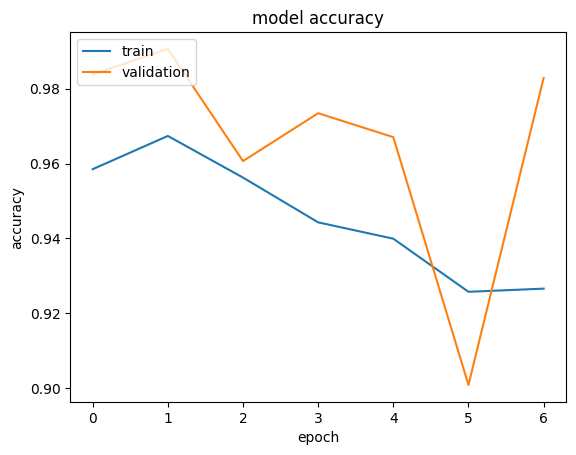

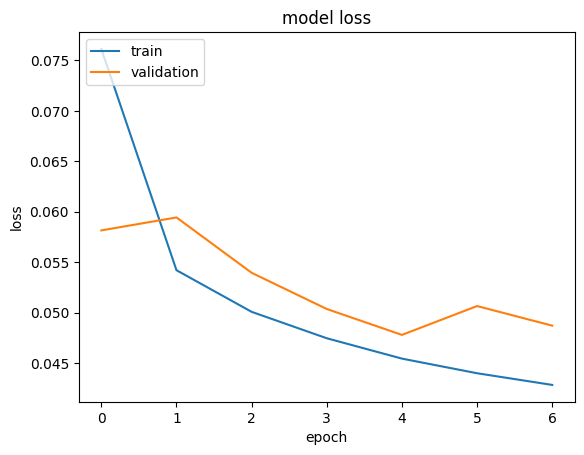

In [27]:
nn_obj.plot_metrics(hist)